# Mask R-CNN for Car Door Detection

In [1]:
import os
import sys
import json
import numpy as np
import time
import skimage.io
from PIL import Image, ImageDraw

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


## Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")


## Configuration
Define configurations for training on the car door dataset.

In [4]:
class CarDoorConfig(Config):
    """
    Configuration for training on the car door dataset.
    Derives from the base Config class and overrides values specific
    to the car door dataset.
    """
    # Give the configuration a recognizable name
    NAME = "car_door"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (car_door)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 378
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # use resnet101 or resnet50
    BACKBONE = 'resnet101'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256) # (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CarDoorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  378
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

# Define the dataset

In [5]:
class CarPartsDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        car_door_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "car_parts"
        for category in car_door_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in car_door_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in car_door_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ 
        Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
#         print(image_id) ##
        
        image_info = self.image_info[image_id]
        
#         print(image_info.items()) ##
#         print(image_info['path']) ##
        mask_name = image_info['path'].split(os.path.sep)[-1][:-4]+'.png' ##
#         print(mask_name)
        mask_path = os.path.join('/home/hangwu/CyMePro/data/annotations/trimaps_with_window', mask_name)
#         print(mask_path)
        
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        mask_with_window = [] ##
        mask_ww = [] ##
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)
                
                ##
                instance_masks_ww = skimage.io.imread(mask_path).astype(np.bool) ##
                mask_ww.append(instance_masks_ww)
                ##

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        ##
        mask_with_window = np.stack(mask_ww, axis = -1)
        
        
#         print(class_ids)
#         print('mask origin: ', mask.shape)
#         print('mask with window: ', mask_with_window.shape)
        return mask_with_window, class_ids # mask, class_ids
    

# Create the Training and Validation Datasets

In [6]:
dataset_train = CarPartsDataset()
dataset_train.load_data('/home/hangwu/CyMePro/botVision/JSON_generator/output/car_door_train.json', '/home/hangwu/CyMePro/data/dataset/train_data')
dataset_train.prepare()

dataset_val = CarPartsDataset()
dataset_val.load_data('/home/hangwu/CyMePro/botVision/JSON_generator/output/car_door_val.json', '/home/hangwu/CyMePro/data/dataset/val_data')
dataset_val.prepare()

## Display a few images from the training dataset

car_door_4_294.png


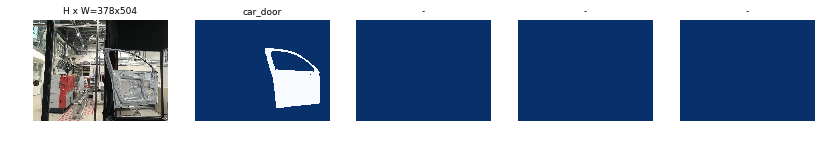

car_door_0_232.png


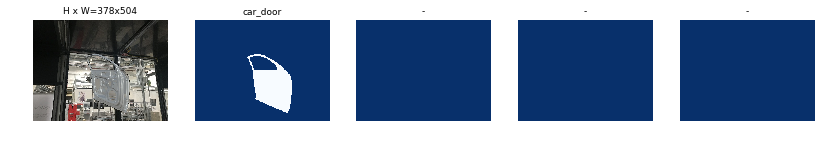

car_door_3_246.png


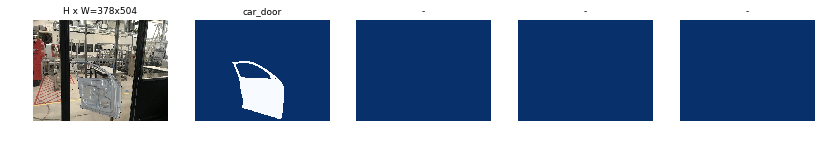

car_door_3_302.png


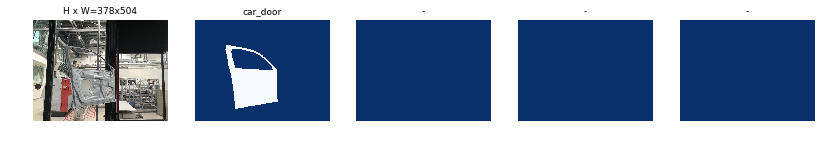

In [7]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook.

In [17]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [18]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 8


## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



In [19]:
# Train the head branches

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 8. LR=0.001

Checkpoint Path: ../logs/car_door20181029T2012/mask_rcnn_car_door_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

/home/hangwu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/hangwu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 9/10
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
Epoch 9/10
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png
car_door_2_280.png
car_door_2_280.png
car_door_2_280.png
car_door_2_280.png
car_door_2_280.png
car_door_2_280.png
car_door_0_4.png
car_door_2_280.png
car_door_2_280.png
Epoch 9/10
car_door_2_280.png
car_door_2_280.png
car_door_0_4.png
car_door_0_4.png
car_door_2_280.png
car_door_2_280.png
car_door_0_4.png
car_door_0_4.png
car_door_0_4.png
car_door_3_231.png
car_door_3_231.png
car_door_3_231.png
car_door_3_231.png
car_door_3_231.png
car_door_3_231.png
car_door_0_4.png
car_door_3_231.png
car_door_3_231.png
car_door_4_3

 94/500 [====>.........................] - ETA: 1:49 - loss: 0.1055 - rpn_class_loss: 3.5200e-04 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0091 - mrcnn_mask_loss: 0.0660car_door_4_287.png


168/500 [=========>....................] - ETA: 1:14 - loss: 0.1078 - rpn_class_loss: 5.5883e-04 - rpn_bbox_loss: 0.0142 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0688car_door_1_15.png


242/500 [=============>................] - ETA: 53s - loss: 0.1261 - rpn_class_loss: 6.5088e-04 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0116 - mrcnn_mask_loss: 0.0721car_door_0_314.png


316/500 [=================>............] - ETA: 36s - loss: 0.1420 - rpn_class_loss: 7.6427e-04 - rpn_bbox_loss: 0.0391 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0732car_door_3_240.png


390/500 [======================>.......] - ETA: 21s - loss: 0.1545 - rpn_class_loss: 8.1053e-04 - rpn_bbox_loss: 0.0467 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0738car_door_0_262.png


464/500 [==========================>...] - ETA: 6s - loss: 0.1498 - rpn_class_loss: 8.0829e-04 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0730car_door_0_192.png


499/500 [============================>.] - ETA: 0s - loss: 0.1509 - rpn_class_loss: 7.9241e-04 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0733car_door_0_351.png
car_door_0_308.png
car_door_0_308.png
car_door_0_308.png
car_door_1_273.png
car_door_0_308.png
500/500 [==============================] - 97s 194ms/step - loss: 0.1508 - rpn_class_loss: 7.9151e-04 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0732 - val_loss: 0.1239 - val_rpn_class_loss: 2.8457e-04 - val_rpn_bbox_loss: 0.0465 - val_mrcnn_class_loss: 0.0013 - val_mrcnn_bbox_loss: 0.0157 - val_mrcnn_mask_loss: 0.0602
car_door_0_351.png
Epoch 10/10
 37/500 [=>............................] - ETA: 1:19 - loss: 0.1033 - rpn_class_loss: 5.0910e-04 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.0602car_door_1_311.png


111/500 [=====>........................] - ETA: 1:05 - loss: 0.1454 - rpn_class_loss: 7.6851e-04 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0709car_door_2_303.png


185/500 [==========>...................] - ETA: 53s - loss: 0.1402 - rpn_class_loss: 6.5656e-04 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0689car_door_3_234.png


259/500 [==============>...............] - ETA: 40s - loss: 0.1363 - rpn_class_loss: 5.8318e-04 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0699car_door_4_311.png


333/500 [==================>...........] - ETA: 28s - loss: 0.1320 - rpn_class_loss: 5.6583e-04 - rpn_bbox_loss: 0.0347 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.0686car_door_1_56.png


407/500 [=======================>......] - ETA: 15s - loss: 0.1491 - rpn_class_loss: 5.7465e-04 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0687car_door_3_270.png


482/500 [===========================>..] - ETA: 3s - loss: 0.1449 - rpn_class_loss: 5.8944e-04 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.0673car_door_1_81.png


499/500 [============================>.] - ETA: 0s - loss: 0.1485 - rpn_class_loss: 5.8531e-04 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0684car_door_0_112.png
car_door_0_308.png
car_door_1_273.png
car_door_1_273.png
car_door_1_273.png
car_door_0_308.png
500/500 [==============================] - 85s 170ms/step - loss: 0.1484 - rpn_class_loss: 5.8539e-04 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0684 - val_loss: 0.1283 - val_rpn_class_loss: 2.3819e-04 - val_rpn_bbox_loss: 0.0237 - val_mrcnn_class_loss: 0.0311 - val_mrcnn_bbox_loss: 0.0160 - val_mrcnn_mask_loss: 0.0572
Training took 4.8 minutes


In [20]:
# Fine tune all layers

start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=12, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 10. LR=0.0001

Checkpoint Path: ../logs/car_door20181029T2012/mask_rcnn_car_door_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          

/home/hangwu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/hangwu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 11/12
car_door_4_249.png
Epoch 11/12car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png

car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_249.png
car_door_4_290.png
car_door_4_290.png
car_door_4_290.png

car_door_2_280.png
car_door_2_280.png
car_door_4_290.png
car_door_2_280.png
car_door_2_280.png
car_door_4_290.png
car_door_2_280.png
car_door_2_280.png
car_door_2_280.png
car_door_4_290.png
car_door_2_280.png
car_door_4_290.png
car_door_2_280.png
car_door_2_280.png
car_door_2_280.png
car_door_4_290.png
car_door_2_280.png
car_door_4_290.png
car_door_4_290.png
car_door_3_231.png
car_door_3_231.png
car_door_4_290.png
car_door_3_231.png
car_door_3_231.png
car_door_0_4.png
car_door_4_290.png
car_door_3_231.png
car_door_0_4.png
car_door_0_4.png
car_door_3_231.png
car_door_3_231.png
car_door_3_231.png
car_door_0_4.png
car_door_3_231.png
car_door_4_314.png
car_door_0_4.png
car_door_4_314.p

131/500 [======>.......................] - ETA: 3:35 - loss: 0.1173 - rpn_class_loss: 6.4901e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0097 - mrcnn_mask_loss: 0.0643car_door_0_80.png


205/500 [===========>..................] - ETA: 2:27 - loss: 0.1109 - rpn_class_loss: 6.1490e-04 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0085 - mrcnn_mask_loss: 0.0631car_door_0_23.png


279/500 [===============>..............] - ETA: 1:41 - loss: 0.1150 - rpn_class_loss: 6.4364e-04 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.0673car_door_1_244.png


353/500 [====================>.........] - ETA: 1:03 - loss: 0.1125 - rpn_class_loss: 6.6199e-04 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0091 - mrcnn_mask_loss: 0.0660car_door_0_38.png


427/500 [========================>.....] - ETA: 30s - loss: 0.1147 - rpn_class_loss: 8.4279e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0091 - mrcnn_mask_loss: 0.0648car_door_3_305.png


499/500 [============================>.] - ETA: 0s - loss: 0.1125 - rpn_class_loss: 7.7402e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.0637car_door_1_132.png
car_door_0_308.png
car_door_0_308.png
car_door_1_273.png
car_door_0_308.png
car_door_0_308.png
500/500 [==============================] - 208s 416ms/step - loss: 0.1124 - rpn_class_loss: 7.7289e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.0637 - val_loss: 0.0644 - val_rpn_class_loss: 1.9495e-04 - val_rpn_bbox_loss: 0.0078 - val_mrcnn_class_loss: 4.3515e-04 - val_mrcnn_bbox_loss: 0.0055 - val_mrcnn_mask_loss: 0.0504
car_door_0_351.png
Epoch 12/12


 74/500 [===>..........................] - ETA: 2:29 - loss: 0.0876 - rpn_class_loss: 5.5518e-04 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0572car_door_0_52.png


148/500 [=======>......................] - ETA: 2:02 - loss: 0.0924 - rpn_class_loss: 5.5203e-04 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.0599car_door_1_210.png


222/500 [============>.................] - ETA: 1:36 - loss: 0.0969 - rpn_class_loss: 4.7947e-04 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.0595car_door_1_6.png


296/500 [================>.............] - ETA: 1:11 - loss: 0.1032 - rpn_class_loss: 4.3923e-04 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.0604car_door_0_19.png


370/500 [=====================>........] - ETA: 45s - loss: 0.1116 - rpn_class_loss: 4.2196e-04 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0081 - mrcnn_mask_loss: 0.0589car_door_1_310.png


444/500 [=========================>....] - ETA: 19s - loss: 0.1095 - rpn_class_loss: 5.0307e-04 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.0592car_door_3_232.png


499/500 [============================>.] - ETA: 0s - loss: 0.1058 - rpn_class_loss: 4.7429e-04 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0593car_door_0_112.png
car_door_0_308.png
car_door_1_273.png
car_door_1_273.png
car_door_1_273.png
car_door_0_308.png
500/500 [==============================] - 177s 354ms/step - loss: 0.1059 - rpn_class_loss: 4.7390e-04 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.0594 - val_loss: 0.0583 - val_rpn_class_loss: 1.5371e-04 - val_rpn_bbox_loss: 0.0065 - val_mrcnn_class_loss: 6.8142e-04 - val_mrcnn_bbox_loss: 0.0046 - val_mrcnn_mask_loss: 0.0464
Training took 7.16 minutes


# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [7]:
class InferenceConfig(CarDoorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [8]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [9]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../logs/car_door20181029T2012/mask_rcnn_car_door_0008.h5
Re-starting from epoch 8


# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

Processing 1 images
image                    shape: (314, 241, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


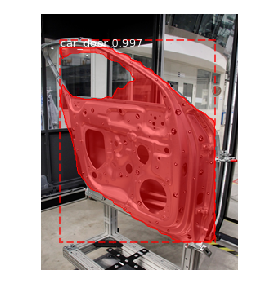

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


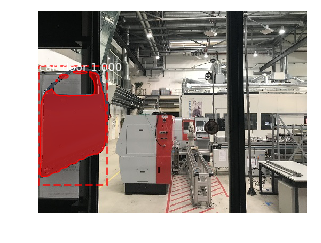

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


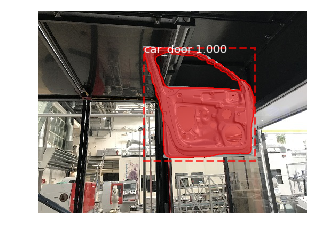

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


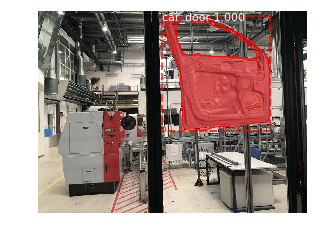

Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


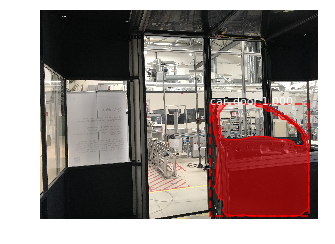

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


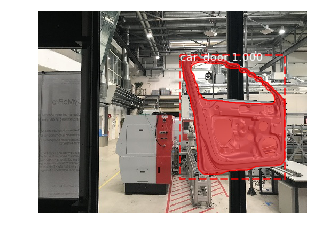

Processing 1 images
image                    shape: (320, 480, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


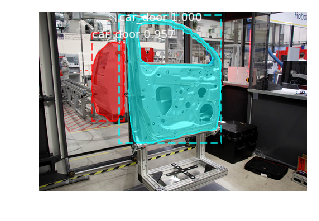

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


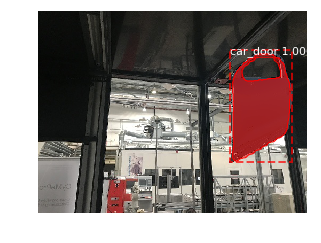

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


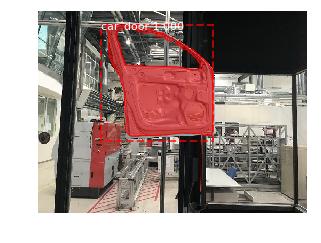

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


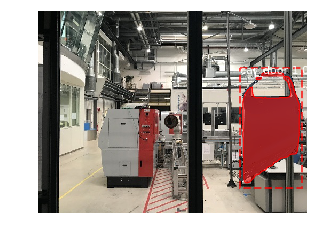

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


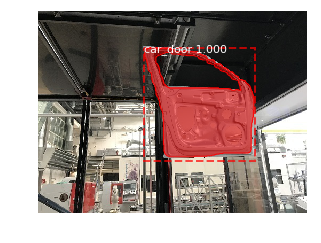

Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


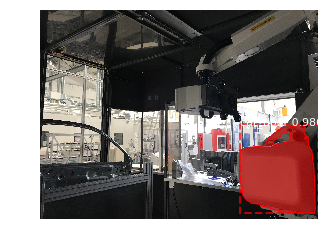

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


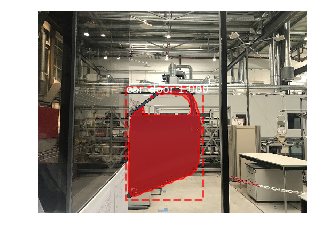

Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


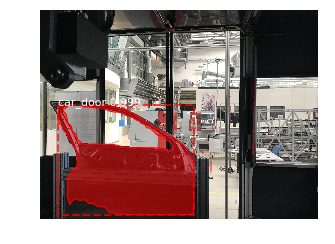

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


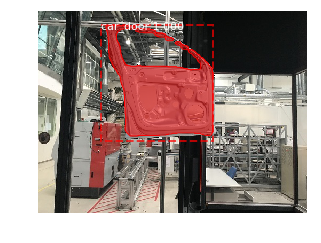

Processing 1 images
image                    shape: (314, 241, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


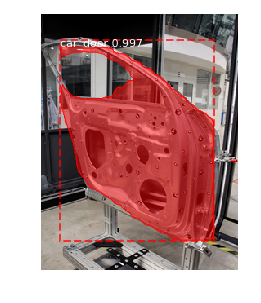

Processing 1 images
image                    shape: (320, 480, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


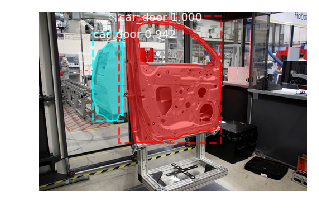

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


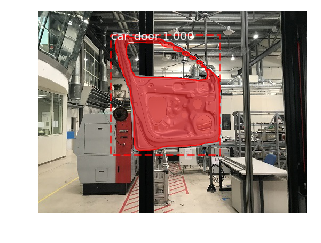

Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


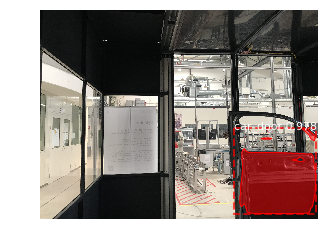

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


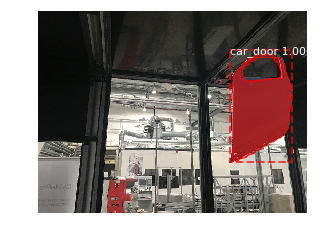

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


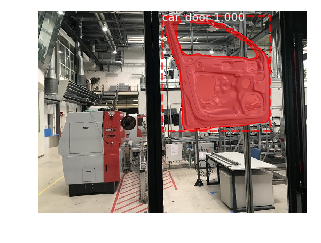

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


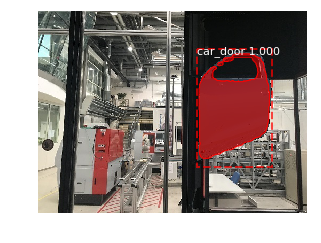

Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


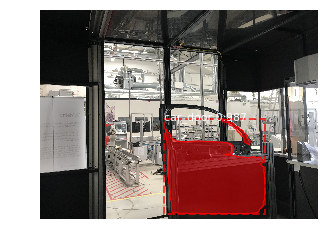

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


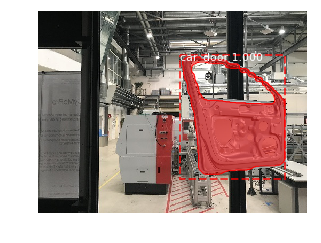

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


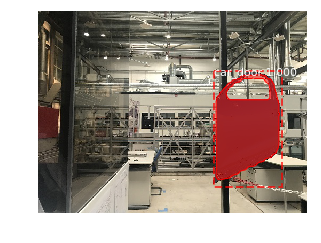

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


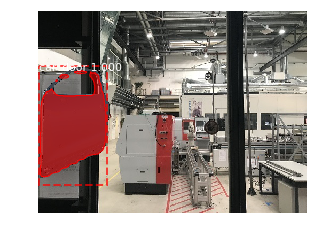

Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32

*** No instances to display *** 



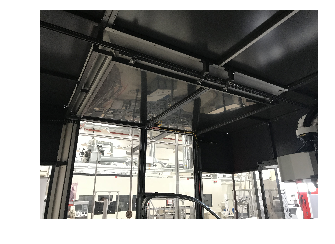

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


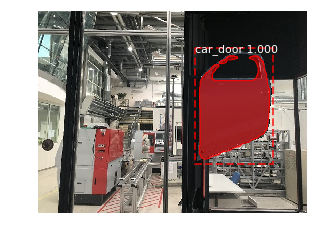

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


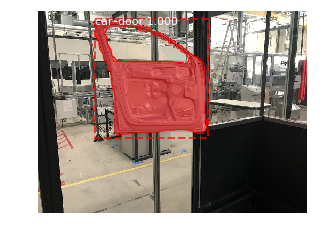

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


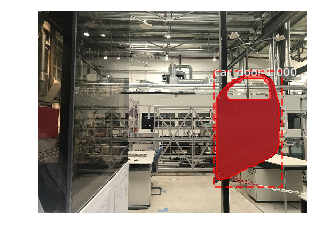

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


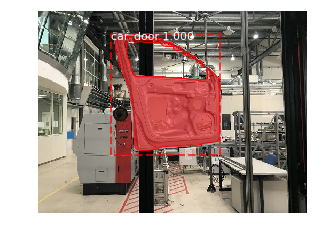

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


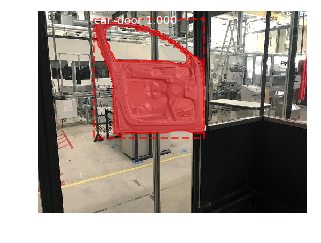

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


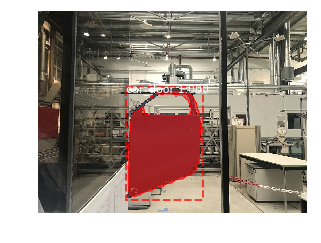

Processing 1 images
image                    shape: (378, 504, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32


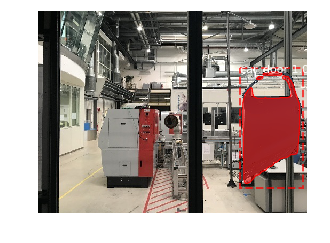

In [10]:
import skimage
real_test_dir = '/home/hangwu/CyMePro/data/test' #'/home/hangwu/CyMePro/data/dataset/test_data'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg', '.JPG']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))